In [1]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/ca_doi_external_appeals"
OUTPUT_DATA_DIR = "./output_data/ca_doi_external_appeals"  # Set to None if you don't want to save non-required data for external use

In [2]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [3]:
# DOI yearly report:
# https://www.insurance.ca.gov/0400-news/0200-studies-reports/0700-commissioner-report/upload/2021Annual-Report-of-the-Insurance-Commissioner.pdf

# DMHC yearly report
# https://dmhc.ca.gov/AbouttheDMHC/DMHCReports/AnnualReports.aspx

# HHS page for IMR determinations from Department of Managed Health Care (applies to HMO IMR appeals)
# https://data.chhs.ca.gov/dataset/independent-medical-review-imr-determinations-trend

# CA DOI, same data for decisions sent to CA department of Insurance.
# Different format, why god :0
# https://interactive.web.insurance.ca.gov/apex_extprd/f?p=192:1:1847478466984:::::

In [4]:
# url = "https://interactive.web.insurance.ca.gov/apex_extprd/f?p=192:4:15780617087096:CSV:NO:RP::"
doi_imr_data_path = os.path.join(INPUT_DATA_DIR, "ca_doi_imr.csv")
# download_file_from_url(url, doi_imr_data_path)

In [5]:
url = "https://data.chhs.ca.gov/dataset/b79b3447-4c10-4ae6-84e2-1076f83bb24e/resource/3340c5d7-4054-4d03-90e0-5f44290ed095/download/independent-medical-review-imr-determinations-trends.csv"
dmhc_imr_data_path = os.path.join(INPUT_DATA_DIR, "ca_dmhc.csv")
download_file_from_url(url, dmhc_imr_data_path)

Target file ./input_data/ca_dmhc.csv already exists.


In [6]:
# # DOI extract Report

# 2021 INDEPENDENT MEDICAL REVIEW SUMMARY REPORT

# Annual Rate of IMR Cases by Total Insured Population
# Plan Type Covered Lives as of
# 12/31/2021
# Major Medical Plans Non-
# Grandfathered Large Group
# 541,996
# Major Medical Plans Non-
# Grandfathered Small Group
# 104,112
# Major Medical Plans Non-
# Grandfathered Individual
# 62,651
# Major Medical Plans Grandfathered
# Large Group
# 12,251
# Major Medical Plans Grandfathered
# Small Group
# 953
# Major Medical Plans Grandfathered
# Individual
# 54,379
# Student Health Plans 76,164
# Total Insured Population 852,506
# Total Number of IMR Cases 191


# Annual Rate of IMR Cases by Health Insurer
# Insurance Company IMR Case Count Annual Rate
# Aetna Life Insurance Company 58 0.0068%
# Anthem Blue Cross Life & Health Insurance
# Company
# 31 0.0036%
# Blue Shield of California Life & Health
# Insurance Company
# 8 0.0009%
# Cigna Health & Life Insurance Company 40 0.0047%
# Health Net Life Insurance Company 27 0.0032%
# Nippon Life Insurance Company of America 3 0.0004%
# Unitedhealthcare Insurance Company 23 0.0027%
# Western Growers Assurance Trust 1 0.001%


# The Number, Type and Resolution of IMR Cases by Health Insurer
# Insurance
# Company
# Total
# IMR
# Cases
# Experiment
# al: Denial
# Overturned
# Experiment
# al: Denial
# Upheld
# Medical
# Necessity:
# Denial
# Overturned
# Medical
# Necessity:
# Denial
# Upheld
# Aetna Life
# Insurance
# Company
# 58 12 10 26 10
# Anthem Blue Cross
# Life & Health
# Insurance
# Company
# 31 4 4 14 9
# Blue Shield of
# California Life &
# Health Insurance
# Company
# 8 2 0 3 3
# Cigna Health & Life
# Insurance
# Company
# 40 7 4 21 8
# Health Net Life
# Insurance
# Company
# 27 2 2 16 7
# Nippon Life
# Insurance
# Company of
# America
# 3 0 0 2 1
# Unitedhealthcare
# Insurance
# Company
# 23 0 5 12 6
# Western Growers
# Assurance Trust
# 1 0 0 0 1


# Check if these numbers correspond to sum of two datasets, or just CDI maintained dataset
# Verified: just CDI database

# Same with population count (total, vs HMO)

### DOI Data

In [7]:
df = pd.read_csv(doi_imr_data_path).sort_values(by="Year", ignore_index=True)

In [8]:
print(f"This dataset contains a total of {len(df)} IMRs administered by CDI.")
for year, count in df["Year"].value_counts(sort=False).items():
    print(f"\t{count} IMRs from {year}")

This dataset contains a total of 4658 IMRs administered by CDI.
	384 IMRs from 2011
	472 IMRs from 2012
	488 IMRs from 2013
	455 IMRs from 2014
	473 IMRs from 2015
	453 IMRs from 2016
	440 IMRs from 2017
	400 IMRs from 2018
	375 IMRs from 2019
	274 IMRs from 2020
	192 IMRs from 2021
	197 IMRs from 2022
	55 IMRs from 2023


In [9]:
def get_overturn_rates_by_category(
    df: pd.DataFrame, cat_col: str, by_year: bool = False
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df["Outcome"].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get("Insurer Denial Overturned", 0)
        decision_data[val]["overall"]["overturned"] = overturned
        decision_data[val]["overall"]["upheld"] = overturn_counts.get("Insurer Denial Upheld", 0)
        decision_data[val]["overall"]["withdrew"] = overturn_counts.get(
            "Insured Withdrew", 0
        )
        decision_data[val]["overall"]["overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df["Year"].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df["Year"] == year]
                overturn_counts = sub_df["Outcome"].value_counts()
                overturned = overturn_counts.get("Insurer Denial Overturned", 0)
                decision_data[val][year]["upheld"] = overturn_counts.get("Insurer Denial Upheld", 0)
                decision_data[val][year]["overturned"] = overturned
                decision_data[val][year]["withrdrew"] = overturn_counts.get(
                    "Insured Withdrew", None
                )
                decision_data[val][year]["overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
    return decision_data

In [10]:
def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were overturned."
    )
    return None

In [11]:
appeal_decision_counts = df["Outcome"].value_counts()
print_appeal_results(appeal_decision_counts)

['Insurer Denial Upheld', 'Insurer Denial Overturned', 'Insured Withdrew']
50% of all original determinations in external appeals were upheld
49% of all original determinations in external appeals were overturned.


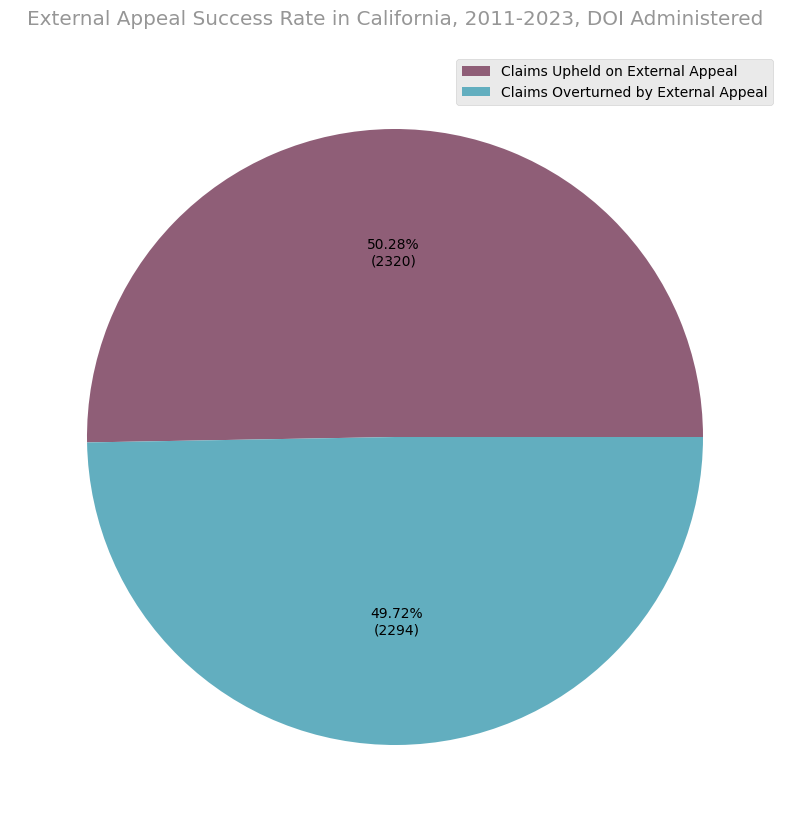

In [12]:
claims_externally_appealed = (
    appeal_decision_counts["Insurer Denial Upheld"] + appeal_decision_counts["Insurer Denial Overturned"]
)
claims_externally_overturned = appeal_decision_counts["Insurer Denial Overturned"]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Success Rate in California, 2011-2023, DOI Administered",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

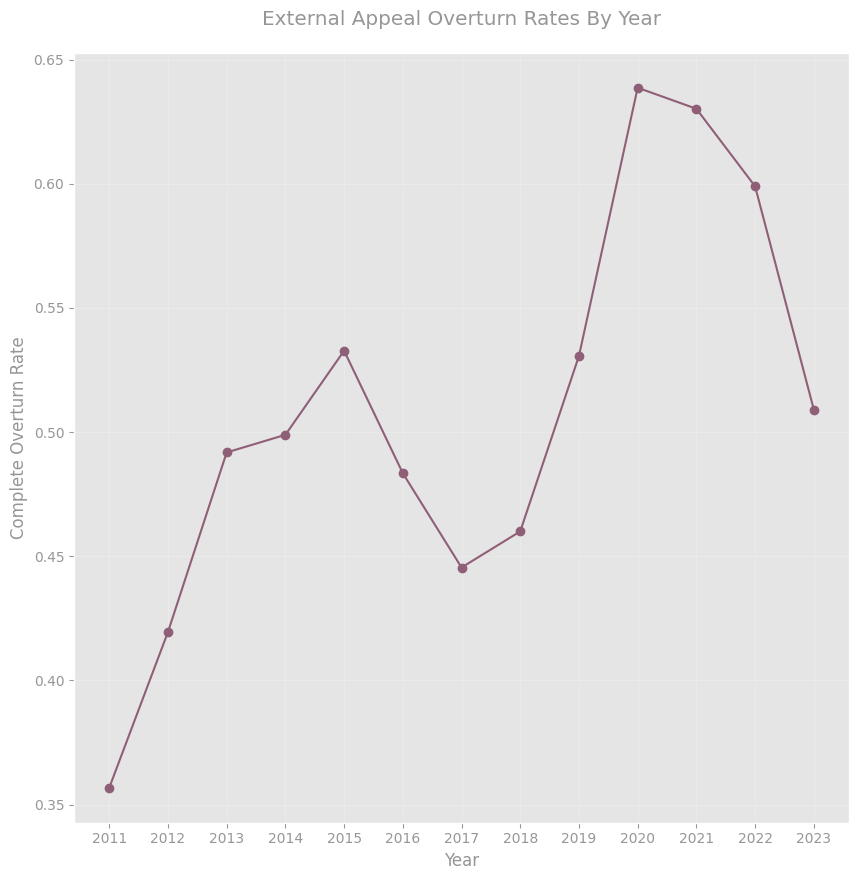

In [13]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, "Year")
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title("External Appeal Overturn Rates By Year")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

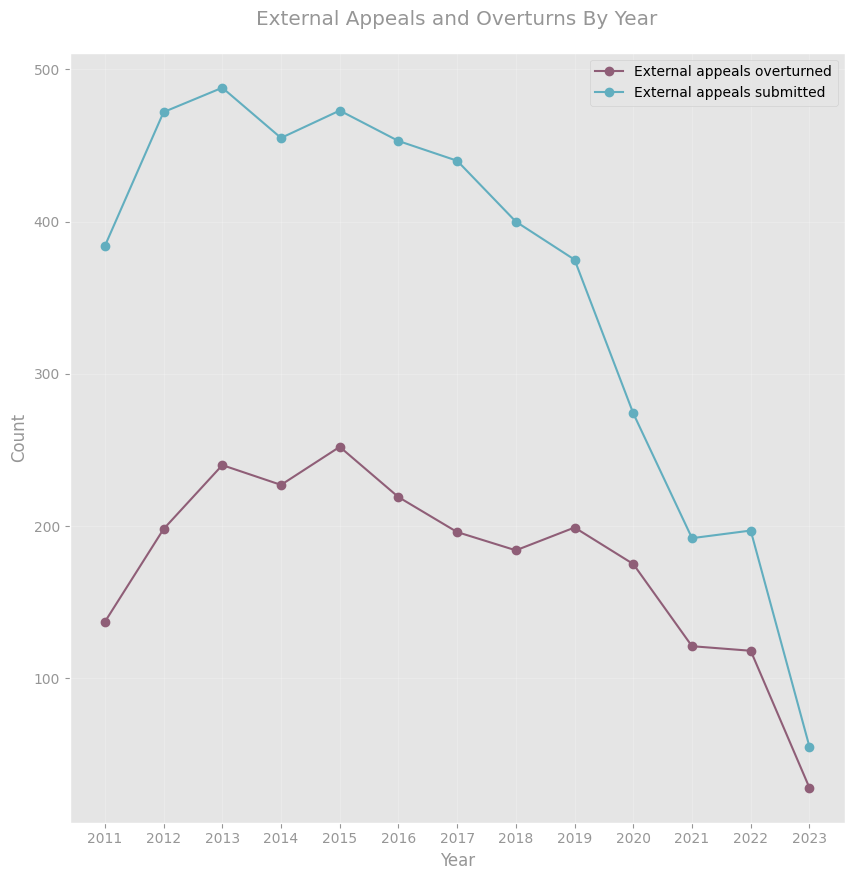

In [14]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title("External Appeals and Overturns By Year")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"]
            + year_data["withdrew"]
            + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(
    dates, overturns_timeseries, "o-", label="External appeals overturned"
)
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

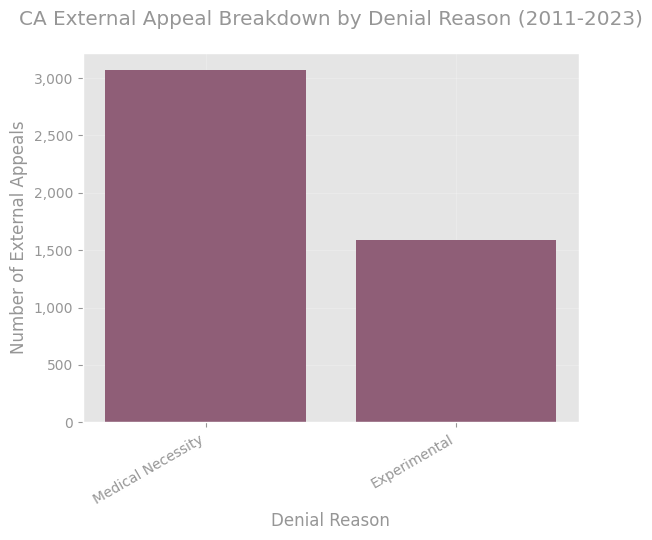

In [15]:
# Breakdown Appeals by Initial Denial Rationale
title = "CA External Appeal Breakdown by Denial Reason (2011-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Reason"
denial_val_counts = df["IMR Type"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
)

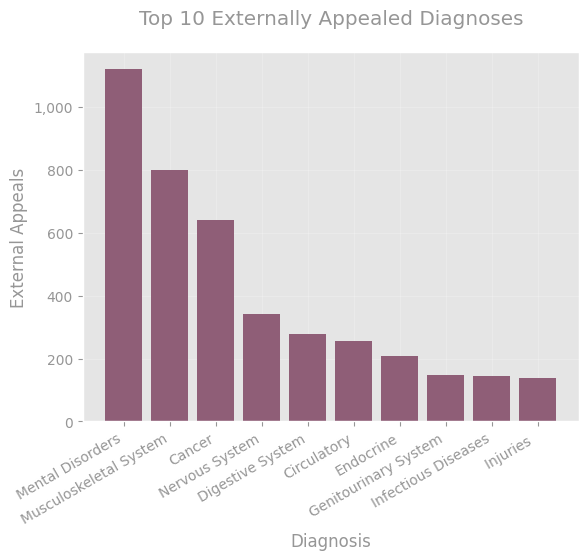

In [16]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
)

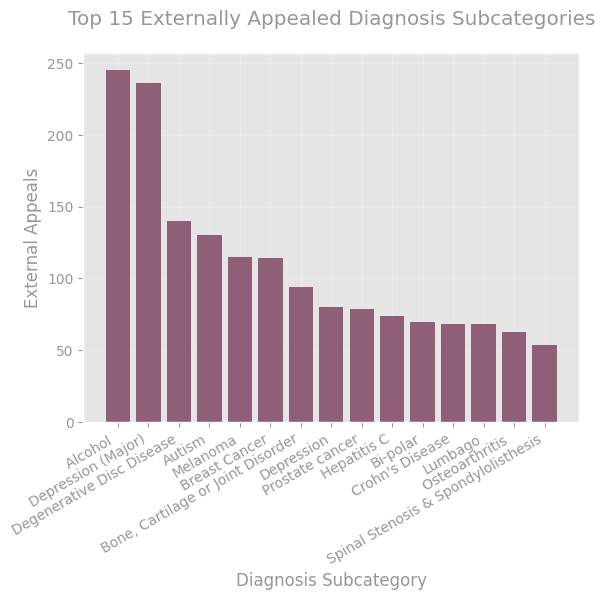

In [17]:
# Diagnosis breakdowns
n = 15
title = f"Top {n} Externally Appealed Diagnosis Subcategories"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df["Diagnosis Subcategory"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(subdiagnosis_val_counts.index)
], subdiagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"),
)

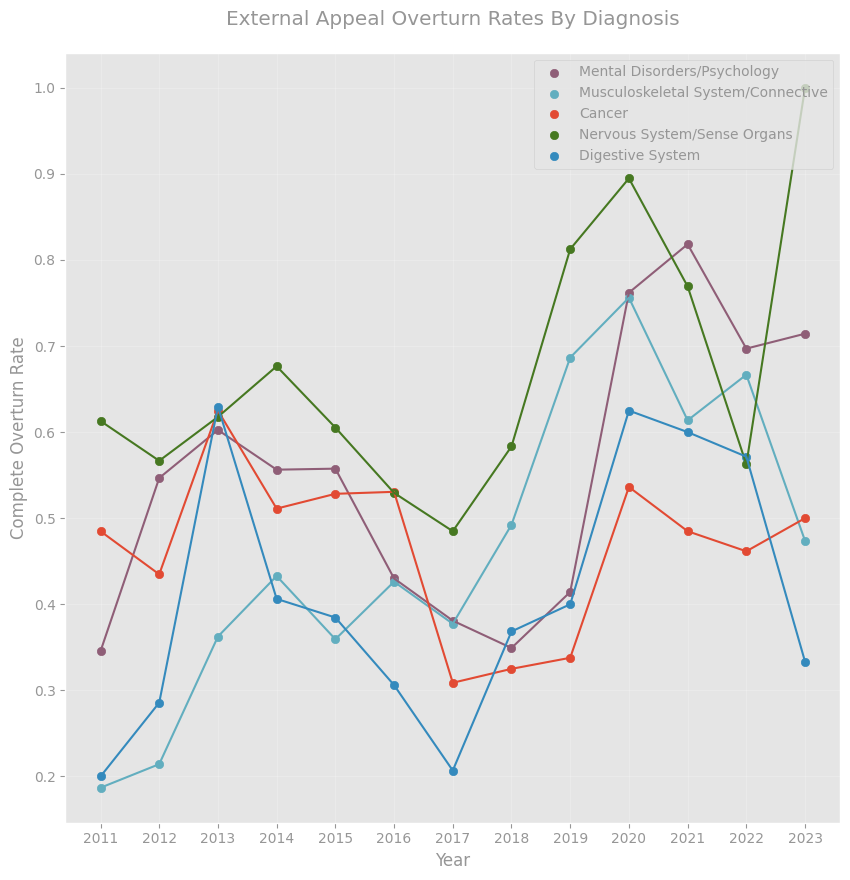

In [18]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis", by_year=True
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title("External Appeal Overturn Rates By Diagnosis")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(
                diagnosis_decision_data[diagnosis][year]["overturn_rate"]
            )
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend()
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

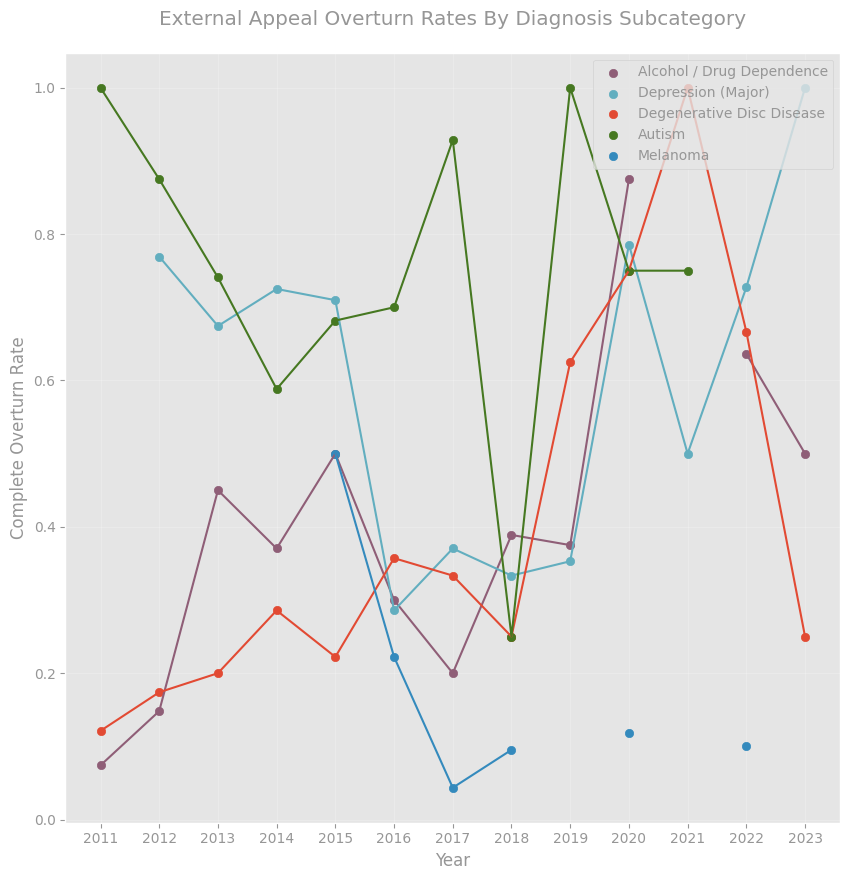

In [19]:
# Plot diagnosis decision rates over time
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis Subcategory", by_year=True
)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Year"].unique())
ax.set_title("External Appeal Overturn Rates By Diagnosis Subcategory")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in subdiagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(
                diagnosis_decision_data[diagnosis][year]["overturn_rate"]
            )
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend()
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis_subcategory.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

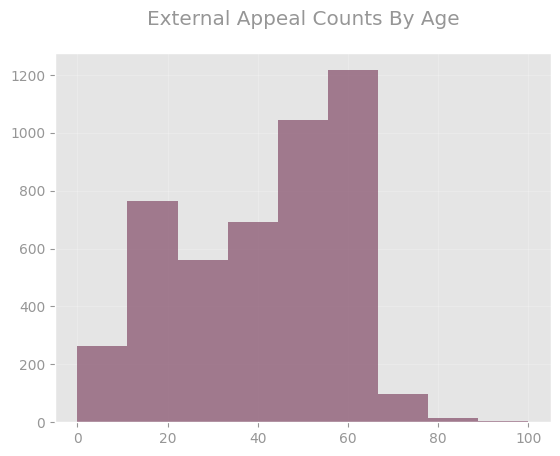

In [20]:
appeal_ages = df[df["Age"] != "-"]["Age"].astype(int)
title = "External Appeal Counts By Age"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
bins=np.linspace(0, 100, 10)
plot_hist(
    appeal_ages,
    bins=bins,
    title=title,
    # val_axis_label=val_axis_label,
    # cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
)

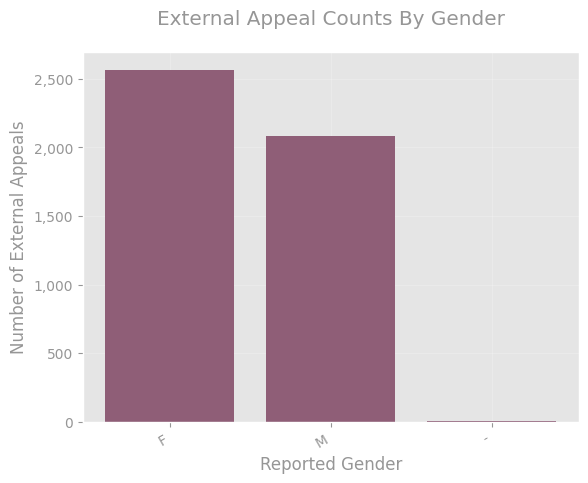

In [21]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeal Counts By Gender"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
)